# Binary Image Classifier: Crack Detection

## Imports

This program primarily utilizes the fastai library, which is built on top of PyTorch. The fastai library is a high-level library that abstracts away much of the complexity of PyTorch, making it easier to use. The fastai library is built on top of PyTorch, and it provides a number of useful features for training models, such as learning rate annealing, weight decay, and more. The fastai library also provides a number of pre-trained models that can be used for transfer learning, which is a technique that allows you to use a pre-trained model as a starting point for training a new model on a different dataset.

In [2]:
from fastai.vision.all import *

## Data Preprocessing

This code utilizes the DataBlock function from the fastai library to preprocess the data. The DataBlock function allows you to define how your data should be loaded, transformed, and split into training and validation sets. In this case, the DataBlock function is used to load the images from the dataset, apply data augmentation, and split the data into training and validation sets.

In [4]:
path = Path('concrete-dataset')

datablock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(460),
    batch_tfms=aug_transforms(size=224, min_scale=0.75)
)

dls = datablock.dataloaders(path)

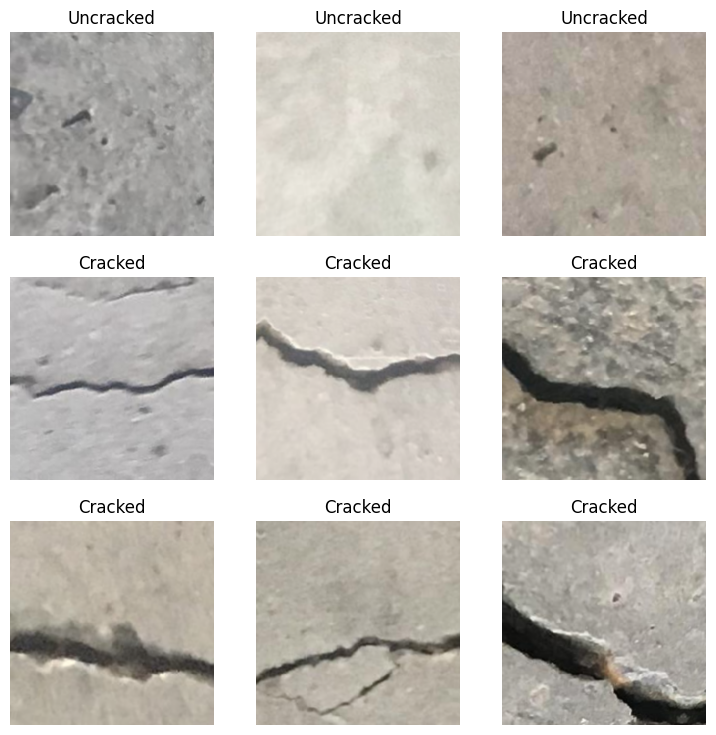

In [ ]:
dls.show_batch(nrows=3, ncols=3)

## Model Training

This code utilizes the cnn_learner function from the fastai library to train a convolutional neural network (CNN) on the preprocessed data. The cnn_learner function allows you to create a CNN model and train it using the fastai library. The cnn_learner function also allows you to use transfer learning by specifying a pre-trained model to use as a starting point for training the new model.

epoch,train_loss,valid_loss,accuracy,time
0,0.023835,0.009867,0.996625,00:51
1,0.017320,0.002065,0.999375,00:52
2,0.010547,0.001380,0.999750,00:51
3,0.007151,0.001404,0.999500,00:50


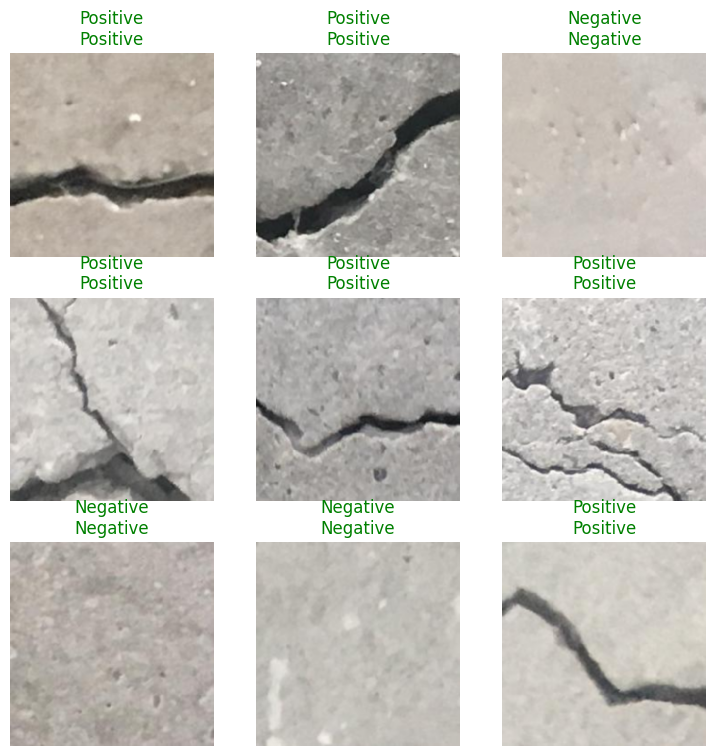

In [11]:
learn = vision_learner(dls, resnet18, metrics=accuracy)
learn.fit_one_cycle(4)
learn.show_results()
learn.export('concrete_classifier.pkl')

## Model Evaluation

This code utilizes the ClassificationInterpretation class from the fastai library to evaluate the trained model. The ClassificationInterpretation class allows you to generate a confusion matrix, plot the most confused classes, and plot the top losses. This information can be used to gain insights into how the model is performing and identify areas for improvement.

In [6]:
# Validate the model and return the loss and metrics
val_loss, *metrics = learn.validate()
print(f'Validation loss: {val_loss}')
for metric, value in zip(learn.metrics, metrics):
    print(f'{metric.name}: {value}')

Validation loss: 0.0009235710022039711
accuracy: 0.9993749856948853


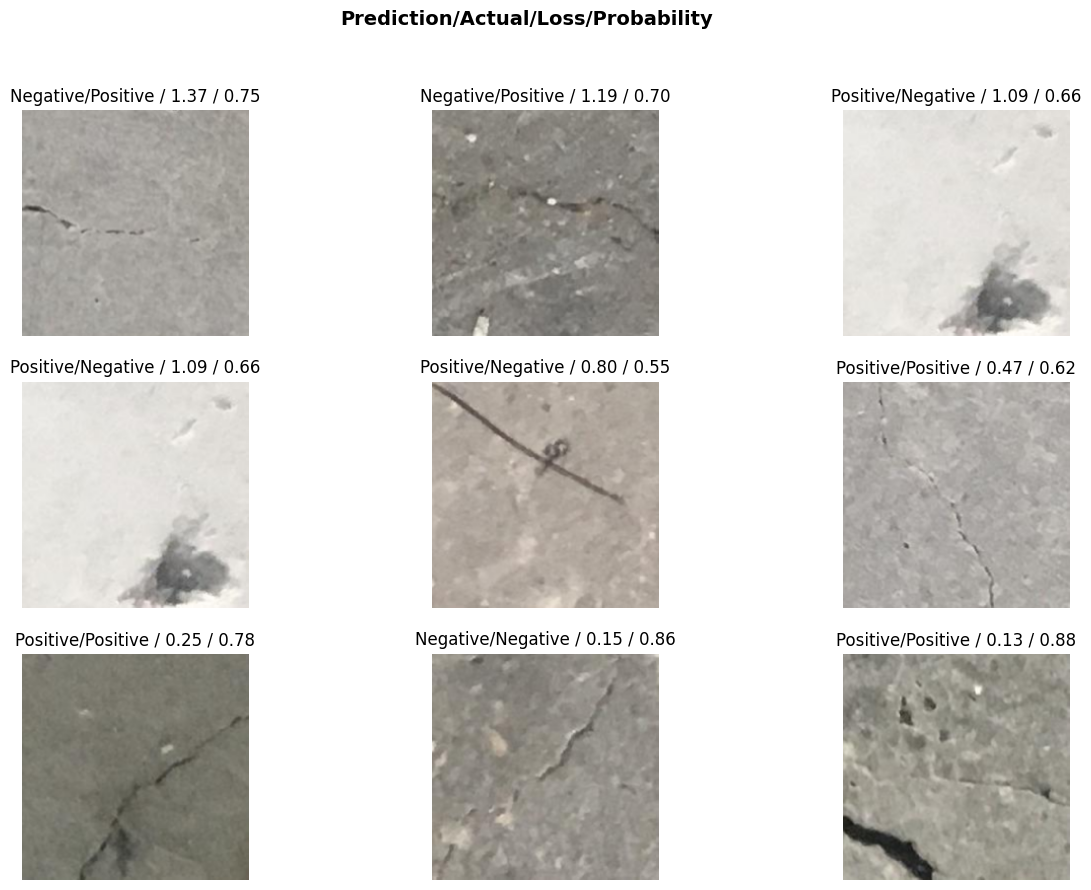

In [7]:
# Plot the top losses
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(15,10))

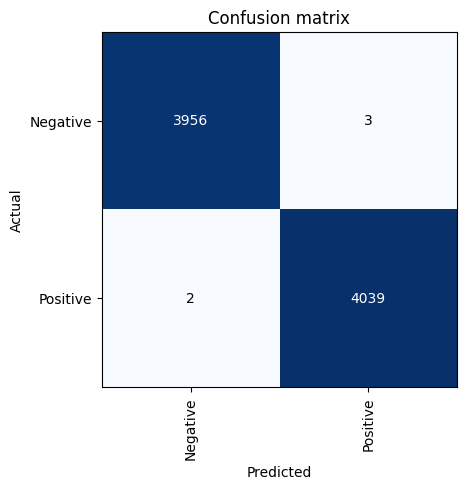

In [8]:
# Plot the confusion matrix
interp.plot_confusion_matrix()

In [9]:
# Get predictions and targets
preds, targets, decoded_preds = learn.get_preds(with_decoded=True)
# Confidence of predictions
confidences = preds.max(dim=1).values

In [10]:
# Load the learner
learn = load_learner('concrete_classifier.pkl')

# Function to create a PILImage object
def get_image(image_path):
    return PILImage.create(image_path)

# Example usage:
image_path = 'images/concrete6.jpg'
img = get_image(image_path)

# Predict the image
pred, pred_idx, probs = learn.predict(img)
print(f'Prediction: {pred}; Probability: {probs[pred_idx]}')

Prediction: Negative; Probability: 0.9999942779541016
